In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
# Dataset Iris
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data)
df.columns = data.feature_names
df['target'] = data.target

In [4]:
print(f"Base de dados com {len(df)} linhas")

Base de dados com 150 linhas


In [5]:
# Principio do Aprendizado de Maquina Supervisionado
data = df.drop('target', axis=1) # Dados
labels = df['target'] # Labels

In [6]:
# csv -> dados
data = data.values
labels = labels.values

In [7]:
# Dividindo dados para o processo de treino, teste e validação
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.2, random_state=41)
data_train, data_validation, labels_train, labels_validation = train_test_split(data_train, labels_train,
                                                                                test_size=0.1,
                                                                                random_state=1)
#https://justpaste.it/cf7rw
print(f'Quantidade de Dados para Treinamento : {len(data_train)}')
print(f'Quantidade de Dados para Validação : {len(data_test)}')
print(f'Quantidade de Dados para Teste : {len(data_validation)}')

Quantidade de Dados para Treinamento : 108
Quantidade de Dados para Validação : 30
Quantidade de Dados para Teste : 12


In [8]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [9]:
dataset = DataSet(data_train,labels_train)
data_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

dataset = DataSet(data_validation,labels_validation)
data_validation = DataLoader(dataset, batch_size=len(data_validation), shuffle=True, num_workers=0)

dataset = DataSet(data_test,labels_test)
data_test = DataLoader(dataset, batch_size=len(data_test), shuffle=True, num_workers=0)

In [10]:
# Criação do Modelo de Rede
    # 4 Entradas (4 Caracteristicas da Flor)
    # 2 Camadas de Neuronio
    # 3 Saidas (3 Rotulos de Flor)
class IrisClassifier(nn.Module) :
    def __init__(self, input_size = 4, hidden_size1=20, hidden_size2 = 10, output_size = 3) :
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, data) :
        data = self.relu(self.fc1(data))
        data = self.relu(self.fc2(data))
        data = self.output(data)
        return data

In [11]:
net = IrisClassifier()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
def train_one_epoch(model,loss_function,optimizer,data_train):
    model.train()
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_train):
        x,y = data
        x = x.to(torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output,y)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [13]:
def validation_one_epoch(model,loss_function, data_validation):
    model.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0
    for i,data in enumerate(data_validation):
        x,y = data
        x = x.to(torch.float)
        output = model(x)
        loss = loss_function(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [14]:
epochs = 1000
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
best_val_loss = 1e9

for epoch in range(epochs):

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(net,criterion,optimizer,data_train)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(net,criterion, data_validation)

    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        model_path = 'test_model'
        torch.save(net.state_dict(),model_path)

    if(epoch % 1 == 0) :
      print(f'Epóca [: {epoch}]')
      print(f'Erro de Treinamento: {train_loss_per_epoch}')
      print(f'Erro de Validação: {val_loss_per_epoch}')
      print(f'Acurácia de Treinamento: {train_accuracy_per_epoch}')
      print(f'Acurácia de Validação: {val_accuracy_per_epoch}')
      print()

Epóca [: 0]
Erro de Treinamento: 1.1222160160541534
Erro de Validação: 1.0406509637832642
Acurácia de Treinamento: 0.26851850748062134
Acurácia de Validação: 0.3333333432674408

Epóca [: 1]
Erro de Treinamento: 1.0364865362644196
Erro de Validação: 0.9900458455085754
Acurácia de Treinamento: 0.37037035822868347
Acurácia de Validação: 0.5833333134651184

Epóca [: 2]
Erro de Treinamento: 0.9603658765554428
Erro de Validação: 0.911292314529419
Acurácia de Treinamento: 0.6851851940155029
Acurácia de Validação: 0.5833333134651184

Epóca [: 3]
Erro de Treinamento: 0.8598757088184357
Erro de Validação: 0.8196525573730469
Acurácia de Treinamento: 0.6851851940155029
Acurácia de Validação: 0.5833333134651184

Epóca [: 4]
Erro de Treinamento: 0.7556104511022568
Erro de Validação: 0.7390986084938049
Acurácia de Treinamento: 0.6851851940155029
Acurácia de Validação: 0.5833333134651184

Epóca [: 5]
Erro de Treinamento: 0.6604265868663788
Erro de Validação: 0.6807865500450134
Acurácia de Treinamento:

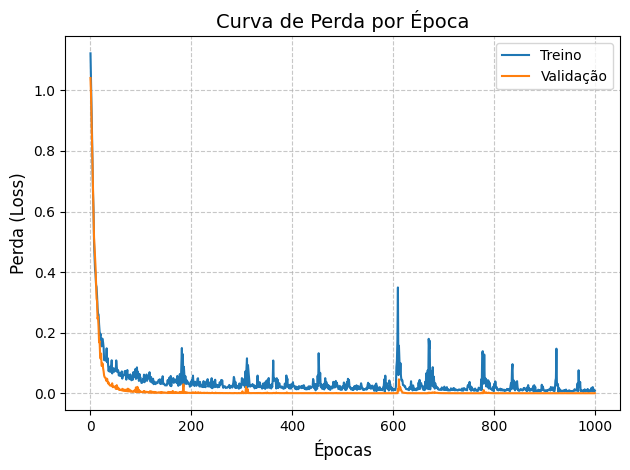

In [21]:
# Plotando as curvas de perda para treino e validação
plt.plot(train_loss_all_epoch, label='Treino')
plt.plot(val_loss_all_epoch, label='Validação')

# Adicionando título e rótulos aos eixos
plt.title('Curva de Perda por Época', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True, linestyle='--', alpha=0.7)  # Adicionando grade
plt.tight_layout()  # Ajuste para não cortar o gráfico
plt.show()

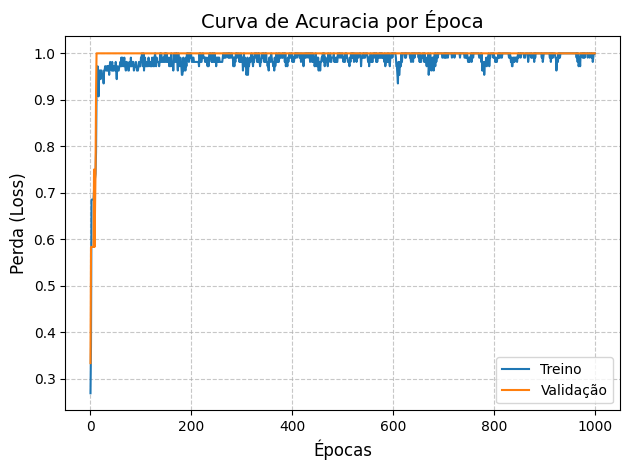

In [16]:
# Plotando as curvas de acuracia para treino e validação
plt.plot(train_accuracy_all_epoch, label='Treino')
plt.plot(val_accuracy_all_epoch, label='Validação')

# Adicionando título e rótulos aos eixos
plt.title('Curva de Acuracia por Época', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True, linestyle='--', alpha=0.7)  # Adicionando grade
plt.tight_layout()  # Ajuste para não cortar o gráfico
plt.show()

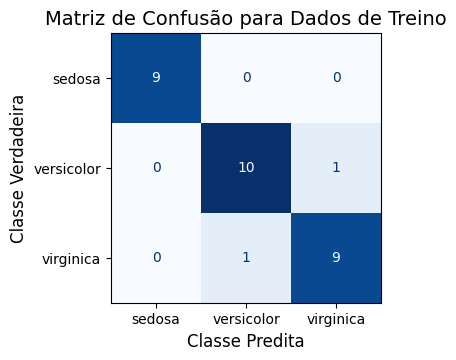

In [17]:
net.train(False)
for data in data_test:
    x_test, y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    cm = confusion_matrix(y_test, y_pred, labels=range(3))

# Exibindo a matriz de confusão graficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sedosa', 'versicolor', 'virginica'])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)

# Melhorando o gráfico
ax.set_title('Matriz de Confusão para Dados de Treino', fontsize=14)
ax.set_xlabel('Classe Predita', fontsize=12)
ax.set_ylabel('Classe Verdadeira', fontsize=12)

plt.tight_layout()
plt.show()

In [18]:
# Colocando o modelo em modo de avaliação (desabilita dropout, batchnorm, etc.)
net.eval()

# Percorrendo os dados de teste
for data in data_test:
    x_test, y_test = data

    # Garantindo que os dados estejam no formato correto (float32)
    x_test = x_test.to(torch.float32)

    # Realizando a previsão
    with torch.no_grad():  # Desabilita o cálculo de gradientes durante a avaliação
        y_pred = net(x_test)
        # Convertendo as predições para as classes com maior probabilidade
        y_pred = torch.argmax(y_pred, dim=1)

    # Convertendo para arrays NumPy ou listas para usar com classification_report
    y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
    y_pred = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred

    # Calculando e imprimindo o relatório de classificação
    print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.91      0.91      0.91        11
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30

